In [38]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from joblib import dump
from sklearn import set_config
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             f1_score, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_tree

from ml_model import PipelineManager, PredictionPipeline
from utils.GPU_models import KerasClassifierModel, gpu_model_hub
from utils.preprocessing_utils import (clean_and_preprocess_datasets,
                                       clean_labs, clean_notas,
                                       clean_sociodemograficos, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


In [2]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
retrain_with_class_weight=False
add_gpu_prediction = False
consolidate_classes = False
cv = 3
n_iter = 24
n_jobs = -2

# False, 'oversample', or 'undersample'
balance_classes = 'oversample'
save_path = Path('data') / 'output' / 'best_model.pickle'

## Data load

In [3]:
df_notas = pd.read_csv('data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('data/sociodemografico.csv', sep=';')

In [4]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [5]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [7]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


## Data Cleaning

In [8]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios)
df_notas = clean_notas(df_notas)

### Merge the sociodemographic data with the medical notes dataset

In [9]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"explica acerca programa, recomienda adherencia..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente diagnostico. Reforz...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL CADA FOSA NASA...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO MES-INFECTOLOGIA VALORACIOJN IN...


## Feature Engineering

In [10]:
# Consolidate the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,top_lab_code,top_lab_avg_value,top_lab_max_value,top_lab_count,total_lab_count,first_lab_date,last_lab_date,date_diff_first_last,date_diff_mean,date_diff_max
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,902213,10.0,10.0,1.0,8.0,1.609114e+18,1.609114e+18,0.0,0.0,0.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Label encoding

In [11]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  977,    94,  2614,  1970, 60586, 47408,  6278, 17437,  2808]))

## Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  195,    19,   523,   394, 12117,  9481,  1256,  3487,   562]))

## Class Balancing

In [13]:
if balance_classes == 'oversample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
elif balance_classes == 'undersample':
    # Using a naive oversampling approach
    sampler = RandomUnderSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([12117, 12117, 12117, 12117, 12117, 12117, 12117, 12117, 12117]))

## Further (optional) feature engineering

In [14]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "universal"

if add_gpu_prediction:
    model_function = gpu_model_hub
    clf = KerasClassifierModel(
        build_fn=model_function,
        class_number=len(df_notas[target_feature].unique()),
        embedding = embedding,
        epochs=400,
        batch_size=400,
        verbose=10,
    )

    clf.fit(X_train[text_feature], y_train)
    clf.plot_learning_curves('data/output/gpu_model')

In [15]:
if add_gpu_prediction:
    y_pred = clf.predict(X_test[text_feature])
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())

In [16]:
if add_gpu_prediction:
    X_pred = clf.predict(df_merge[text_feature])
    df_merge['GPU_prediction'] = X_pred
    df_merge

## Hyperparameter Setup

In [17]:
# Select the numerical features that will be used in the model
numerical_features = list(
    set(
        [
            "Edad",
            "top_lab_avg_value",
            "top_lab_max_value",
            "top_lab_count",
            "total_lab_count",
            "date_diff_mean",
            "date_diff_max",
            "first_lab_date",	
            "last_lab_date",
            "date_diff_first_last",
        ]
        + list(df_merge.drop(columns="IDRecord").select_dtypes(include="int64").columns)
    )
)

# Now select the categorical features
categorical_features = [
    "Genero",
    "GrupoEtnico",
    "AreaResidencial",
    "EstadoCivil",
    # "TSangre",
    # "Tipo",
    "top_lab_code",
]

In [18]:
# Add the GPU prediction if we are using a GPU model for predicting the data
if 'GPU_prediction' in df_merge:
    categorical_features.append('GPU_prediction')

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

# param_grid = {
#     "n_estimators": np.linspace(1, 100, 10, dtype=int),
#     "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
#     "bootstrap": [True, False],
# }
# estimator = RandomForestClassifier()
# pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 200, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta": np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 5, dtype=float),
    "reg_alpha": np.linspace(0, 10, 5, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    "C": np.linspace(0, 5, 20, dtype=float),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "class_weight": ["balanced", None],
    "coef0": np.linspace(0, 5, 20, dtype=float),
    "degree": np.linspace(1, 5, 10, dtype=int),
}
estimator = SVC()
pipeline.add_estimator(estimator, param_grid)


pipeline.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo', 'top_lab_code']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   Simp...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'más',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                               'este',
                                                                       

## Hyperparameter tuning

In [19]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=df_merge[target_feature])

scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }
best_model = pipeline.find_best_model(
    X_train,
    y_train,
    cv=cv,
    n_iter=n_iter,
    n_jobs=n_jobs,
    scoring=scoring,
    random_state=7,
    refit='Weighted_F1',
    verbose = 1,
    # error_score='raise',
    )

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-packages

In [20]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo', 'top_lab_code']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('s...
                               eval_metric=None, gamma=0.75, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.391111106, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=0.5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=133, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [21]:
with pd.option_context('display.max_columns', None):
    display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_preprocessor__categorical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,split2_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
13,2927.019331,418.247386,27.247819,6.765131,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.55,7.5,0.0,133,0.5,10,0.75,0.391111,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.961459,0.963522,0.968447,0.964476,0.002931,1,0.961004,0.963028,0.968085,0.964039,0.002978,1
22,3263.499802,85.269670,13.004425,1.232433,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),1.0,7.5,10.0,155,0.5,4,1.0,0.391111,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.912355,0.914170,0.916646,0.914390,0.001759,2,0.909610,0.911421,0.914309,0.911780,0.001935,2
9,4637.102893,102.864680,740.833001,77.103272,"CountVectorizer(ngram_range=(2, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),KNNImputer(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),1.0,2.5,5.0,200,5.375,6,0.5,0.064444,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.889989,0.887046,0.888559,0.888531,0.001202,3,0.885285,0.882442,0.884806,0.884178,0.001243,3
16,2258.856141,155.391990,13.257121,1.448650,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.55,7.5,10.0,111,5.375,6,0.0,0.118889,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.883442,0.880031,0.881324,0.881599,0.001406,4,0.878159,0.874818,0.876882,0.876619,0.001376,4
2,1675.718222,19.246505,24.591542,1.526825,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(strategy='most_frequent'),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.55,10.0,7.5,155,5.375,8,0.75,0.336667,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.867321,0.868202,0.867817,0.867780,0.000360,5,0.862921,0.863841,0.864298,0.863687,0.000573,5
19,776.601629,43.212018,17.206026,1.190146,"CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),1.0,2.5,5.0,200,5.375,4,0.0,0.173333,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.862672,0.863057,0.857968,0.861233,0.002314,6,0.857151,0.857758,0.853153,0.856021,0.002043,6
17,2956.147911,161.927125,590.680769,152.608078,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),StandardScaler(),KNNImputer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.55,0.0,10.0,200,5.375,10,0.25,0.118889,0.4,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.852851,0.857308,0.

In [22]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
13,1,1,2927.019331,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(),VarianceThreshold(),0.964476,0.964039
22,2,2,3263.499802,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.914390,0.911780
9,3,3,4637.102893,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),KNNImputer(),VarianceThreshold(),0.888531,0.884178
16,4,4,2258.856141,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.881599,0.876619
2,5,5,1675.718222,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.867780,0.863687
19,6,6,776.601629,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(),VarianceThreshold(),0.861233,0.856021
17,7,7,2956.147911,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),StandardScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.856492,0.849845
7,8,9,2969.838952,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.846332,0.840547
10,9,8,355.472931,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.848890,0.840053
12,10,10,2796.973885,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.830431,0.822872


In [23]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
13,1,1,2927.019331,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(),VarianceThreshold(),0.964476,0.964039
22,2,2,3263.499802,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.914390,0.911780
9,3,3,4637.102893,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),KNNImputer(),VarianceThreshold(),0.888531,0.884178
16,4,4,2258.856141,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.881599,0.876619
2,5,5,1675.718222,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.867780,0.863687
19,6,6,776.601629,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(),VarianceThreshold(),0.861233,0.856021
17,7,7,2956.147911,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),StandardScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.856492,0.849845
7,8,9,2969.838952,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.846332,0.840547
10,9,8,355.472931,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.848890,0.840053
12,10,10,2796.973885,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.830431,0.822872


In [24]:
# Retrain the model using a sample-weighting mechanism to try to compensate for the dataset imbalance
if retrain_with_class_weight:
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train,
    )

    best_model.fit(X_train, y_train, estimator__sample_weight=sample_weights)

## Scoring

In [25]:
score = pipeline.score(X_test, y_test)
score

,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,0.984938,0.865978,0.850723,0.865978,0.831306,0.866503,"[[658, 3, 5, 0, 62, 53, 0, 1, 0], [0, 74, 0, 0...","[[0.0058677700690220975, 2.6752751074568835e-0...",precision recall f1-score ...


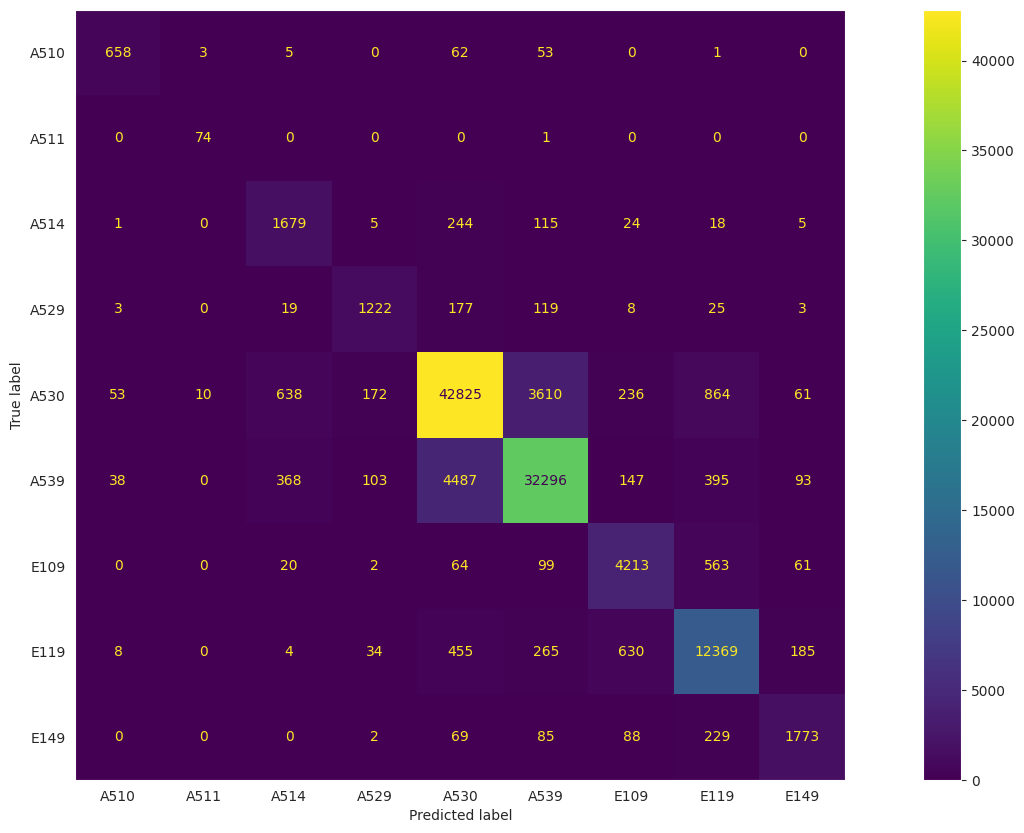

In [26]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

In [27]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A510,0.86,0.84,0.85,782.00
A511,0.85,0.99,0.91,75.00
A514,0.61,0.80,0.70,2091.00
A529,0.79,0.78,0.78,1576.00
A530,0.89,0.88,0.88,48469.00
A539,0.88,0.85,0.87,37927.00
E109,0.79,0.84,0.81,5022.00
E119,0.86,0.89,0.87,13950.00
E149,0.81,0.79,0.80,2246.00
accuracy,0.87,0.87,0.87,0.87


# Model Characterization

## Model Features

In [28]:
best_model.named_steps['feature_selector'].get_feature_names_out(best_model.named_steps['preprocessor'].get_feature_names_out())

array(['categorical__Genero_Hombre', 'categorical__Genero_Mujer',
       'categorical__GrupoEtnico_Blanco', ..., 'text__zuletas carrera 59',
       'text__zumbidos oidos prevenir', 'text__zumos frutas platanos'],
      dtype=object)

In [29]:
# Model test
print(f'Predicted :{label_encoder.inverse_transform(best_model.predict(X_test.iloc[905].to_frame().T))}, real: {label_encoder.inverse_transform([y_test[905]])}')

Predicted :['A539'], real: ['A539']


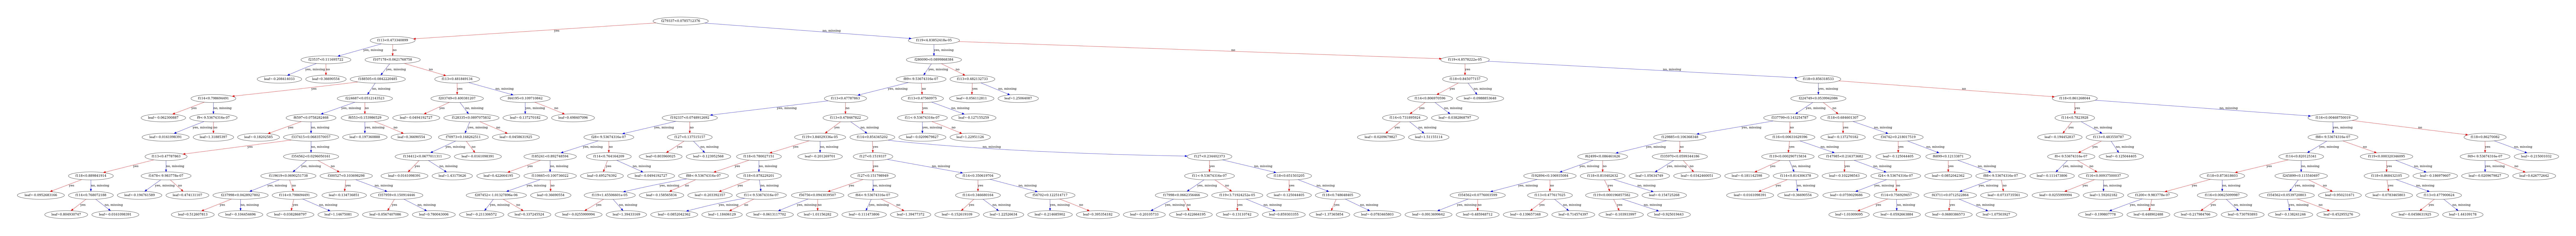

In [44]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=800)
plot_tree(best_model.named_steps['estimator'], num_trees=2, ax=ax)
plt.show()

## Saving the best performing model and pipeline

### Saving the best model

In [30]:
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))

['data/output/best_model_score.pickle']

### Create and save the full prediction pipeline

In [31]:
prediction_pipeline = PredictionPipeline(estimator=best_model, preprocessing_fn=clean_and_preprocess_datasets, label_encoder=label_encoder)
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(
    prediction_pipeline,
    str(save_path.parent / f"prediction_pipeline{save_path.suffix}"),
)

['data/output/prediction_pipeline.pickle']

### Test the pipeline

### Preprocessed data

In [32]:
prediction_pipeline.predict(X_test, preprocess_data=False)

array(['E119', 'A539', 'A530', ..., 'A539', 'A510', 'A530'], dtype=object)

### Raw data

In [33]:
prediction_pipeline.predict(
    X={
        "df_sociodemograficos": pd.read_csv("data/sociodemografico.csv", sep=";"),
        "df_laboratorios": pd.read_csv("data/laboratorios.csv", sep=";"),
        "df_notas": pd.read_csv("data/notas.csv", sep=";"),
    }
)

array(['A539', 'E119', 'E119', ..., 'E119', 'E119', 'A539'], dtype=object)

In [34]:
clean_data = clean_and_preprocess_datasets({
        "df_sociodemograficos": pd.read_csv("data/sociodemografico.csv", sep=";"),
        "df_laboratorios": pd.read_csv("data/laboratorios.csv", sep=";"),
        "df_notas": pd.read_csv("data/notas.csv", sep=";"),
    })

In [35]:
from utils.preprocessing_utils import preprocess_json

import json
with open('scripts/utils/sample_example.json') as in_file:
    sample_data = json.load(in_file)
sample_data

preprocess_json(sample_data)

{'df_sociodemograficos':    Edad Genero GrupoEtnico AreaResidencial EstadoCivil TSangre  IDRecord
 0    39  Mujer     Mestizo     Zona Urbana    Separado     NaN         0,
 'df_laboratorios':    Codigo             Fecha Valor  IDRecord
 0  902045  22/02/2022 18:43   NaN         0
 1  902046  22/02/2022 18:43    20         0,
 'df_notas':                   Tipo                                               Plan  \
 0  Confirmado Repetido  - Paciente se remite para analisis de urologia...   
 
    IDRecord  
 0         0  }

In [36]:
prediction_pipeline.predict(
    X=preprocess_json(sample_data))

array(['E119'], dtype=object)